In [1]:
#!pip install yfinance
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from datetime import datetime
from datetime import timedelta
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

### **Not starting on 01/01/2000 anymore - now we start on 26/01/2015 - the date of the earliest earnings call where there is available data on the expected EPS.**


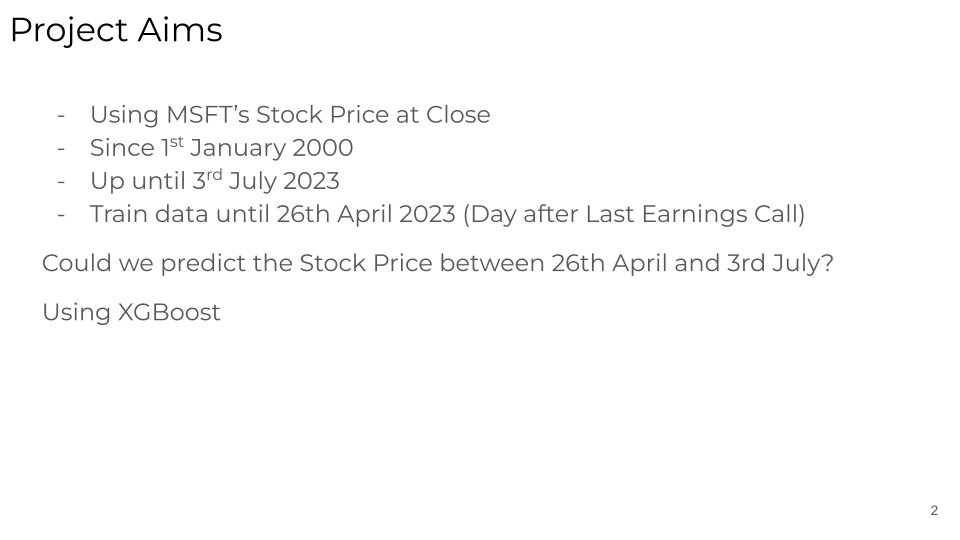

In [2]:
# Loaded the start date - This is the date from when the data will be uploaded - 1st Jan 2000
start_date = '2015-01-26'
start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')

# We will train the model up until the 3rd of July, and then predict on the 10th of July

# The end_date is the last day for which we will load training data - 3rd July 2023
end_date = '2023-07-03'
end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')

# The target date is the date for which we want to predict the stock price - 10th July 2023
target_date = '2023-07-10'
target_date_dt = datetime.strptime(target_date, '%Y-%m-%d')

### Loading MSFT Data up until 10th July

In [3]:
# Choose the ticker symbol
tickerSymbol = 'MSFT'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
# We want to load the data up until the 10th July - we will restrict the dataframe to the 3rd July later
msft = tickerData.history(period='1d', end= (target_date_dt + timedelta(days = 1))) #We need to add 1 day to the end of the range so that the time range goes up to the desired target date

# Visualise
msft

ERROR:yfinance:MSFT: No price data found, symbol may be delisted (period=1d)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


In [4]:
# Choose the ticker symbol
tickerSymbol = 'MSFT'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
# We want to load the data up until the 10th July - we will restrict the dataframe to the 3rd July later
msft = tickerData.history(period='1d', start= start_date_dt, end= (target_date_dt + timedelta(days = 1))) #We need to add 1 day to the end of the range so that the time range goes up to the desired target date

# Visualise
msft

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-01-26 00:00:00-05:00,40.585318,40.697577,39.929047,40.593952,42525500,0.0,0.0
2015-01-27 00:00:00-05:00,37.088067,37.303947,36.362713,36.837646,169164000,0.0,0.0
2015-01-28 00:00:00-05:00,36.906726,36.949901,35.542367,35.568272,84507100,0.0,0.0
2015-01-29 00:00:00-05:00,35.343755,36.371339,35.222863,36.276352,63585300,0.0,0.0
2015-01-30 00:00:00-05:00,35.879136,35.905044,34.842915,34.886093,78004900,0.0,0.0
...,...,...,...,...,...,...,...
2023-07-03 00:00:00-04:00,337.164281,338.864060,334.559933,335.971436,12508700,0.0,0.0
2023-07-05 00:00:00-04:00,333.088771,339.609590,332.730935,336.130493,18172400,0.0,0.0
2023-07-06 00:00:00-04:00,335.285551,340.941571,333.496313,339.231842,28161200,0.0,0.0


In [5]:
# Let's isolate the column with the closing price, as we will not be using be using any of the other columns in this data frame
msft = msft[['Close']]

# Resetting the date index so that we can manipulate the daytime object to contain a year-month-day formatted date
# msft = msft.reset_index()
# msft['Date'] = msft['Date'].dt.date
# msft = msft.set_index('Date')

# Send the Close column is what we are going to use as an indicator for the price, we can rename it for greater clarity
msft = msft.rename(columns = {'Close': 'Price'})
msft

,Price
Date,
2015-01-26 00:00:00-05:00,40.593952
2015-01-27 00:00:00-05:00,36.837646
2015-01-28 00:00:00-05:00,35.568272
2015-01-29 00:00:00-05:00,36.276352
2015-01-30 00:00:00-05:00,34.886093
...,...
2023-07-03 00:00:00-04:00,335.971436
2023-07-05 00:00:00-04:00,336.130493
2023-07-06 00:00:00-04:00,339.231842


In [6]:
msft.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2128 entries, 2015-01-26 00:00:00-05:00 to 2023-07-10 00:00:00-04:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   2128 non-null   float64
dtypes: float64(1)
memory usage: 33.2 KB


Now, let's restrict the data frame to the last day of trading that we will feed into our model, eg the `end_date` of the 3rd July 2023



In [7]:
# Then, restrict the df
df = msft[:end_date]

# Remove the timezone information and set the time to midnight
df.index = df.index.tz_convert(None).normalize()

df

,Price
Date,
2015-01-26,40.593952
2015-01-27,36.837646
2015-01-28,35.568272
2015-01-29,36.276352
2015-01-30,34.886093
...,...
2023-06-27,332.571899
2023-06-28,333.844238
2023-06-29,333.049011


In [8]:
df['Price'].iloc[0:3]

Date
2015-01-26    40.593952
2015-01-27    36.837646
2015-01-28    35.568272
Name: Price, dtype: float64

# Initialise randomised sampling to create an input and output array

In [9]:
# Initialize lists to store input and output sequences
input_sequences = []
output_sequences = []

In [10]:
# Define the sequence length (12 for input, 13 for output)
sequence_length = 91

In [11]:
# Iterate through the data to create sequences
for i in range(len(df['Price']) - sequence_length - 1): #Iterate through the first 5899 rowss and leave the last 13 rows alone
    input_seq = df['Price'].iloc[i:i + sequence_length]  # Get (the rolling) 12 rows from the Price column and add them to a Pandas Series called `input seq`.
    output_seq = df['Price'].iloc[i + sequence_length]  # Get the corresponding 13th output value and add it to a Pandas Series called `output_seq`
    input_sequences.append(list(input_seq))
    output_sequences.append(output_seq)

In [12]:
# Convert the lists to NumPy arrays
input_sequences = np.array(input_sequences)
output_sequences = np.array(output_sequences)

## Separate the input & output sequences into Training and Testing - Change % Training and Testing

In [13]:
# Pick the % of the dataset that we want to set aside for testing
pct_testing = 20

# Convert it into an index location in the input array for slicing
slicing_index = len(input_sequences) * pct_testing/100  #this makes a float so it needs to be casted onto an `int`
slicing_index = int(slicing_index)


# Slice the input and output sequences to separate training and test data
X_train = input_sequences[:-slicing_index]
y_train = output_sequences[:-slicing_index]
X_test = input_sequences[-slicing_index:]
y_test = output_sequences[-slicing_index:]

### What this is doing:
![](https://drive.google.com/uc?export=view&id=1DmAs743q67xDinxbiVE_DLVZn61IjtLo)

In [14]:
print('X_train has shape ', X_train.shape, ' and its data is', X_train)
print('y_train has shape ', y_train.shape, ' and its data is', y_train)
print('X_test has shape ', X_test.shape, ' and its data is', X_test)
print('y_test has shape ', y_test.shape, ' and its data is', y_test)

X_train has shape  (1626, 91)  and its data is [[ 40.59395218  36.83764648  35.56827164 ...  41.0697403   41.0084877
   40.5795784 ]
 [ 36.83764648  35.56827164  36.27635193 ...  41.0084877   40.5795784
   40.38700485]
 [ 35.56827164  36.27635193  34.88609314 ...  40.5795784   40.38700485
   40.02812195]
 ...
 [273.36203003 270.91101074 271.41879272 ... 328.6958313  323.65698242
  325.2517395 ]
 [270.91101074 271.41879272 270.81335449 ... 323.65698242 325.2517395
  329.44918823]
 [271.41879272 270.81335449 274.38751221 ... 325.2517395  329.44918823
  328.81323242]]
y_train has shape  (1626,)  and its data is [ 40.38700485  40.02812195  39.95811081 ... 329.44918823 328.81323242
 332.17889404]
X_test has shape  (406, 91)  and its data is [[270.81335449 274.38751221 275.8815918  ... 329.44918823 328.81323242
  332.17889404]
 [274.38751221 275.8815918  274.4362793  ... 328.81323242 332.17889404
  332.40438843]
 [275.8815918  274.4362793  274.16287231 ... 332.17889404 332.40438843
  334.511

# Create MLP Regressor Model

## Create a Preliminary Model and Observe Performance

In [15]:
from sklearn.neural_network import MLPRegressor

In [16]:
model1 = MLPRegressor()

In [17]:
model1.fit(X_train, y_train)

MLPRegressor()

In [18]:
y_pred1 = model1.predict(X_test)

In [19]:
print(y_pred1)
print(y_pred1.shape)

[332.84938239 333.74072539 331.06913006 334.65742565 334.45935325
 335.2710843  335.01449401 332.33336503 328.41367525 326.85930963
 326.37522655 324.79784971 325.21114739 321.60891048 324.88116525
 325.32249805 331.11779598 330.53552204 333.00102359 335.7491699
 330.10207362 324.93255421 326.16745658 321.87591223 319.51122984
 320.39622022 328.20831116 330.60860954 334.08247115 338.81607926
 339.73596452 339.85721757 338.03848872 339.21790736 330.73749892
 328.45725043 321.14062688 318.03581788 313.3618849  310.71236863
 314.60175438 321.29451084 317.15482876 314.84050035 307.89837042
 303.48181484 305.62931637 302.19683299 295.53610937 290.41501931
 290.4945488  295.68658499 303.30118586 303.4438949  303.25367777
 298.49124182 301.7933033  304.12170976 304.00897164 312.60160627
 305.14604813 305.1761286  304.78745918 305.56034615 307.54639646
 306.90895125 297.37812948 294.64933459 290.1493788  288.48468289
 296.0973181  305.91507604 303.46773875 306.42193371 304.45807576
 296.229105

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate Mean Squared Error (MSE)
mse_1 = mean_squared_error(y_test, y_pred1)

# Calculate Mean Absolute Error (MAE)
mae_1 = mean_absolute_error(y_test, y_pred1)

# Calculate RMSE
rmse_1 = np.sqrt(mse_1)

# Calculate R-squared (R2) score
r2_1 = r2_score(y_test, y_pred1)

# Print the results
print(f"Mean Squared Error (MSE): {mse_1}")
print(f"Mean Absolute Error (MAE): {mae_1}")
print(f"RMSE: {rmse_1}")
print(f"R-squared (R2) Score: {r2_1}")


Mean Squared Error (MSE): 128.54427633871725
Mean Absolute Error (MAE): 8.928528016149107
RMSE: 11.33773682613586
R-squared (R2) Score: 0.8754676554730051


### Compare model predictions with `y_test`

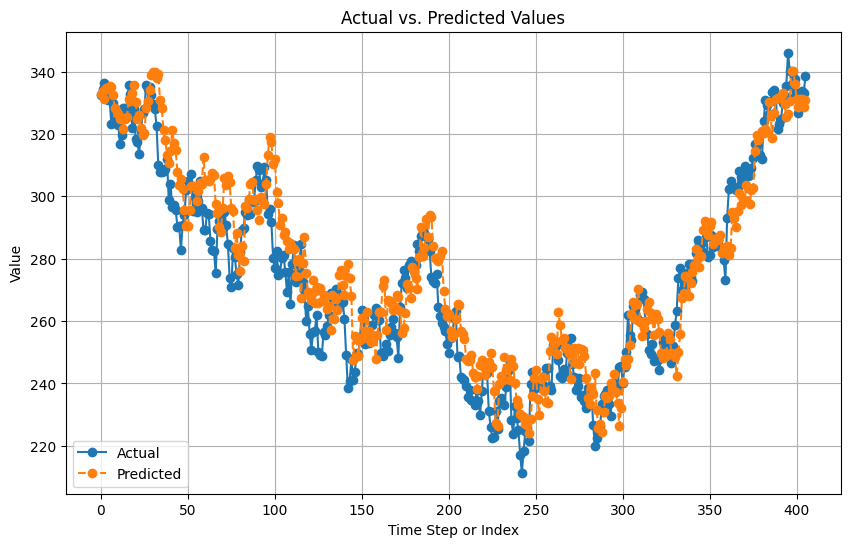

In [21]:
# Create an array for the x-axis (indices or time steps)
x = np.arange(len(y_test))

# Create a line plot for y_pred and y_test
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(x, y_test, label='Actual', marker='o', linestyle='-')
plt.plot(x, y_pred1, label='Predicted', marker='o', linestyle='--')

# Add labels and a legend
plt.xlabel('Time Step or Index')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.title('Actual vs. Predicted Values')
plt.grid(True)
plt.show()


In [22]:
score = np.sqrt(mean_squared_error(y_test, y_pred1))
print(f'RMSE Score on Test set: {score:0.2f}')
print(f'R^2 Score on Test set: {r2_1:0.2f}')

RMSE Score on Test set: 11.34
R^2 Score on Test set: 0.88


# Cross-Validation of Regressor Parameters

In [23]:
df = df.astype(float)

In [24]:
from sklearn.preprocessing import StandardScaler
# Use StandardScaler to scale the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)  # Scaling the  data


In [25]:
df_scaled.shape

(2124, 1)

In [26]:
df.shape

(2124, 1)

In [27]:
# Initialize lists to store input and output sequences
input_sequences_scaled = []
output_sequences_scaled = []

# Define the sequence length (12 for input, 13 for output)
sequence_length = 91

# Iterate through the data to create sequences
for i in range(len(df_scaled) - sequence_length - 1): #Iterate through the first 5899 rowss and leave the last 13 rows alone
    input_seq = df_scaled[i:i + sequence_length]  # Get (the rolling) 12 rows from the Price column and add them to a Pandas Series called `input seq`.
    output_seq = df_scaled[i + sequence_length]  # Get the corresponding 13th output value and add it to a Pandas Series called `output_seq`
    input_sequences_scaled.append(list(input_seq))
    output_sequences_scaled.append(output_seq)

# Convert the lists to NumPy arrays
input_sequences_scaled = np.array(input_sequences_scaled)
output_sequences_scaled = np.array(output_sequences_scaled)

# Pick the % of the dataset that we want to set aside for testing
pct_testing = 20

# Convert it into an index location in the input array for slicing
slicing_index = len(input_sequences_scaled) * pct_testing/100  #this makes a float so it needs to be casted onto an `int`
slicing_index = int(slicing_index)


# Slice the input and output sequences to separate training and test data
X_train_cv = input_sequences_scaled[:-slicing_index]
y_train_cv = output_sequences_scaled[:-slicing_index]
X_test_cv = input_sequences_scaled[-slicing_index:]
y_test_cv = output_sequences_scaled[-slicing_index:]

In [28]:
# Check the dimensions of X_train
X_train_cv.shape

(1626, 91, 1)

In [29]:
# It needs to be a 2D numpy array for sklearns's MLP Regressor. Therefore, we need to flatten it.
# Flatten X_train
X_train_cv = X_train_cv.reshape((X_train_cv.shape[0], -1))  # Reshape to (4720, 12 * 1)
X_test_cv = X_test_cv.reshape((X_test_cv.shape[0], -1))

In [30]:
# Check the dimensions of X_train
X_train_cv.shape

(1626, 91)

In [31]:
X_train_cv

array([[-1.14055712, -1.18103247, -1.19471038, ..., -1.13543036,
        -1.13609037, -1.140712  ],
       [-1.18103247, -1.19471038, -1.1870806 , ..., -1.13609037,
        -1.140712  , -1.14278704],
       [-1.19471038, -1.1870806 , -1.20206107, ..., -1.140712  ,
        -1.14278704, -1.14665412],
       ...,
       [ 1.36759084,  1.34118035,  1.34665186, ...,  1.96382965,
         1.90953449,  1.92671849],
       [ 1.34118035,  1.34665186,  1.34012807, ...,  1.90953449,
         1.92671849,  1.9719473 ],
       [ 1.34665186,  1.34012807,  1.37864073, ...,  1.92671849,
         1.9719473 ,  1.96509468]])

In [32]:
# Check the dimensions of y_train
y_train_cv.shape

(1626, 1)

In [33]:
# It needs to be a 1D numpy array for sklearns's MLP Regressor. Therefore, we need to flatten it.
# Flatten y_train
y_train_cv = y_train_cv.ravel()
y_test_cv = y_test_cv.ravel()

In [34]:
# Check the dimensions of y_train
y_train_cv.shape

(1626,)

In [35]:
param_grid = {'max_iter': [12, 15, 17, 20, 22, 24, 26],
              'hidden_layer_sizes': [(18,),(20,),(22,),(24,),(26,),(28,),(30,)]}

In [36]:
# %%time
# regressor = GridSearchCV(
#     estimator = MLPRegressor(),
#     param_grid = param_grid,
#     n_jobs = 4,
#     error_score='raise'
# )
# regressor.fit(X_train, y_train) #X_train and y_train have been scaled using StandardScaler
# print(regressor.best_score_)
# print(regressor.best_estimator_)

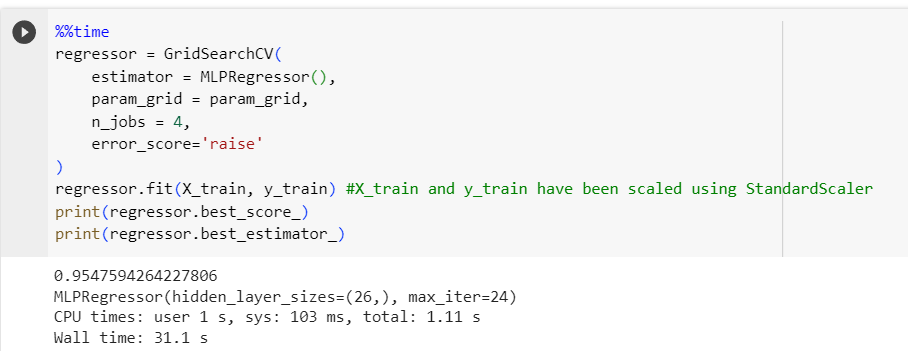

In [37]:
best_layer_size = (26,)
best_iter_max = 24

## Run MLP Regressor and create predictions on Scaled data.

In [38]:
%%time
model_cv = MLPRegressor(hidden_layer_sizes = best_layer_size,
                        max_iter = best_iter_max
                        )

model_cv.fit(X_train_cv, y_train_cv)
y_pred_cv = model_cv.predict(X_test_cv)
print(y_pred_cv)
print(y_pred_cv.shape)

[1.95654814 2.00147012 2.01317708 2.02681753 2.04929416 2.03401747
 2.04721876 2.05513985 2.03250698 2.0230566  1.96215851 1.90974913
 1.91659573 1.94062759 1.95082095 1.93105071 1.87123031 1.85991233
 1.90923847 1.95142652 1.97975218 1.94996519 1.99122118 1.96495822
 1.98156466 1.88322469 1.92012802 1.96061877 1.94731499 2.03359372
 2.02169311 2.05275868 2.07969451 2.03085791 2.0391565  1.9464403
 1.99674056 1.94565655 1.9840321  1.97417707 1.92503496 1.99963133
 1.9911171  1.95143093 1.99833637 1.95137571 1.92535129 1.84469755
 1.83750678 1.74571984 1.83258298 1.81537334 1.8355022  1.9168628
 1.87010704 1.91133235 1.97297182 2.00995827 1.98894555 1.94194211
 1.94634092 1.9489903  1.93587671 1.889233   1.95994969 1.93580875
 1.91711777 1.81802086 1.78512944 1.80458541 1.91793437 1.89514914
 2.0070152  1.92884963 1.94949682 1.97537385 1.95920824 1.93119385
 1.84176182 1.89052368 1.80059238 1.85888624 1.87432807 1.85286582
 1.97710045 1.97025922 1.96428437 1.87091931 1.87033896 1.924706

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (24) reached and the optimization hasn't converged yet.
  warnings.warn(


In [39]:
# Calculate Mean Squared Error (MSE)
mse_2 = mean_squared_error(y_test_cv, y_pred_cv)

# Calculate Mean Absolute Error (MAE)
mae_2 = mean_absolute_error(y_test_cv, y_pred_cv)

# Calculate RMSE
rmse_2 = np.sqrt(mse_2)

# Calculate R-squared (R2) score
r2_2 = r2_score(y_test_cv, y_pred_cv)

# Print the results
print(f"Mean Squared Error (MSE): {mse_2}")
print(f"Mean Absolute Error (MAE): {mae_2}")
print(f"RMSE: {rmse_2}")
print(f"R-squared (R2) Score: {r2_2}")

Mean Squared Error (MSE): 0.08446685062353176
Mean Absolute Error (MAE): 0.2465925308981534
RMSE: 0.2906318128208469
R-squared (R2) Score: 0.29521564147637114


# Un-scale the predictions to see the 10th of July

In [40]:
trading_dates = msft[end_date:target_date].index.tz_convert(None).normalize()
trading_dates = trading_dates[1:] # Exclude the 3rd July 2023 because that's part of the Training Data
# trading_dates

# Extend the sequences up to the 10th of July
# First, copy each - 'input' and 'output'
extended_input_sequences = input_sequences.copy()  # Make a copy of the input sequences
extended_output_sequences = output_sequences.copy()  # Make a copy of the output sequences

for date in trading_dates:
    # Predict for the next day
    prediction = model_cv.predict(extended_input_sequences[-1].reshape(1, -1))  # Save the prediction for the last sequence in `prediction`
    print('For each date, we can print the `prediction` array ',prediction, 'and its shape, ', prediction.shape)
    extended_input_sequences_2 = np.vstack((extended_input_sequences, np.append(extended_input_sequences[-1, 1:], prediction)))
    extended_output_sequences_2 = np.append(extended_output_sequences, prediction)

# # Print or use the predictions for July 4th to July 10th
print("Predictions for July 10th:", extended_output_sequences[-1])

For each date, we can print the `prediction` array  [321.1408054] and its shape,  (1,)
For each date, we can print the `prediction` array  [321.1408054] and its shape,  (1,)
For each date, we can print the `prediction` array  [321.1408054] and its shape,  (1,)
For each date, we can print the `prediction` array  [321.1408054] and its shape,  (1,)
Predictions for July 10th: 338.5061950683594


***stuck here

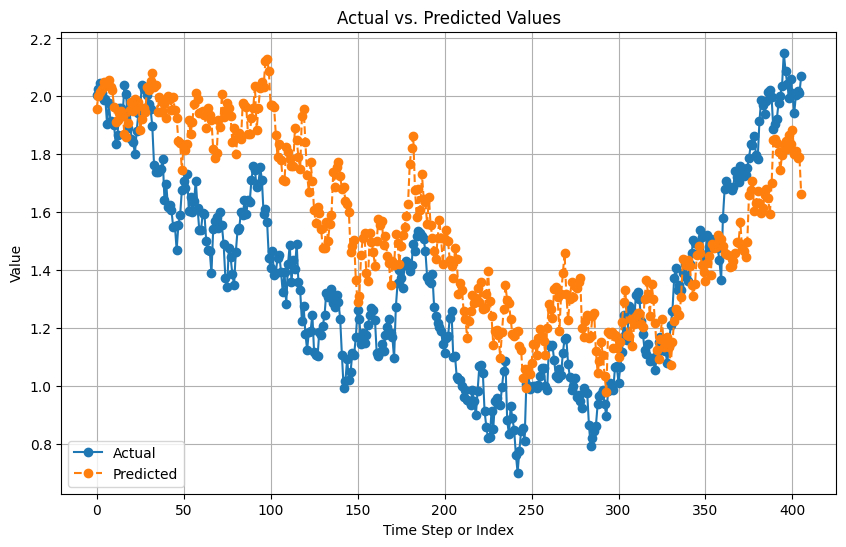

In [41]:
# Create an array for the x-axis (indices or time steps)
x = np.arange(len(y_test))

# Create a line plot for y_pred and y_test
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(x, y_test_cv, label='Actual', marker='o', linestyle='-')
plt.plot(x, y_pred_cv, label='Predicted', marker='o', linestyle='--')

# Add labels and a legend
plt.xlabel('Time Step or Index')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.title('Actual vs. Predicted Values')
plt.grid(True)
plt.show()

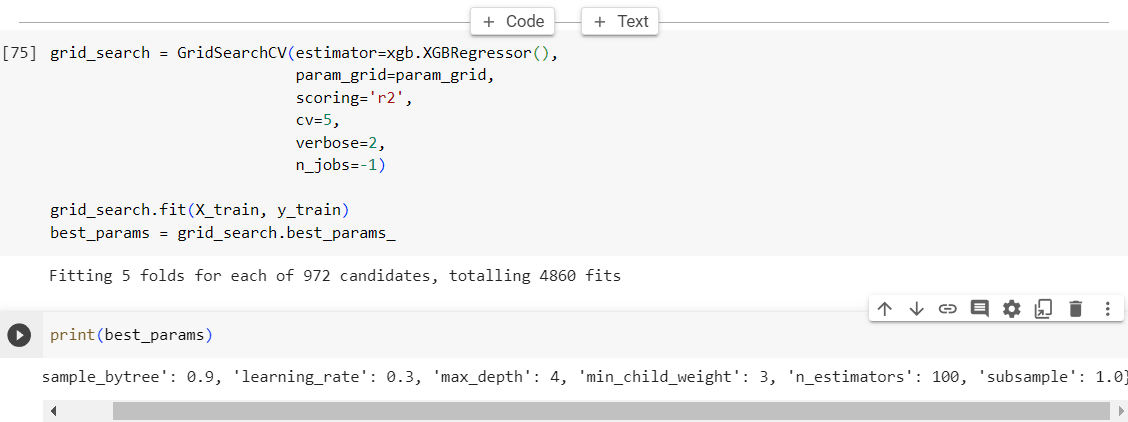

The output of this cell has been saved in a new variable `best_params_saved_1st`

In [42]:
best_params_saved_1st = {'colsample_bytree': 0.9, 'learning_rate': 0.3, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}

In [43]:
print(best_params_saved_1st)

{'colsample_bytree': 0.9, 'learning_rate': 0.3, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


In [44]:
param_grid_2nd = {
    'learning_rate': [0.25, 0.3, 0.4, 0.5],
    'max_depth': [4],
    'n_estimators': [50, 75, 100],
    'min_child_weight': [2, 3, 4],
    'subsample': [0.95, 0.975, 1.0],
    'colsample_bytree': [0.85, 0.9, 0.95]
}

In [45]:
# grid_search = GridSearchCV(estimator=xgb.XGBRegressor(),
#                            param_grid=param_grid_2nd,
#                            scoring='r2',
#                            cv=5,
#                            verbose=2,
#                            n_jobs=-1)

# grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_

In [46]:
# print(best_params)

The above code took 14 minutes to run and had the following output:
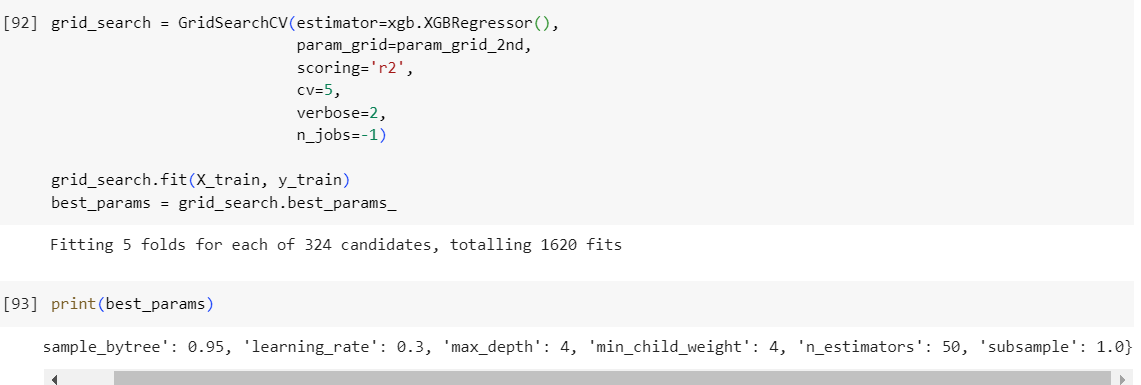

These parameters have been saved in the variable `best_params_2nd`.

In [47]:
best_params_2nd = {'colsample_bytree': 0.95, 'learning_rate': 0.3, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 50, 'subsample': 1.0}

Now, let's use these parameters to fit our model

In [48]:
best_model = xgb.XGBRegressor(**best_params_2nd)
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.95, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [49]:
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [50]:
print(f'RMSE Score on Test set: {rmse:0.2f}')
print(f'R^2 Score on Test set: {r2:0.2f}')

RMSE Score on Test set: 23.14
R^2 Score on Test set: 0.48


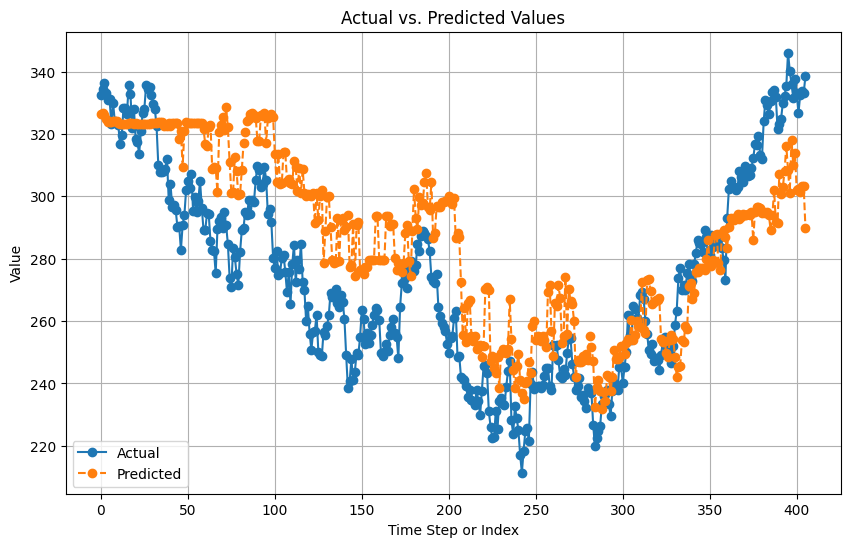

In [51]:
# Create an array for the x-axis (indices or time steps)
x = np.arange(len(y_test))

# Create a line plot for y_pred and y_test
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(x, y_test, label='Actual', marker='o', linestyle='-')
plt.plot(x, y_pred, label='Predicted', marker='o', linestyle='--')

# Add labels and a legend
plt.xlabel('Time Step or Index')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.title('Actual vs. Predicted Values')
plt.grid(True)
plt.show()

In [52]:
extended_input_sequences.shape

(2032, 91)

# Predict on the scaled dataset

In [53]:
for date in trading_dates:
    # Predict for the next day
    scaled_predictions = model_cv.predict(extended_input_sequences[-1].reshape(1, -1))  # Predict for the last sequence
    print('For each date, we can print the `prediction` array ',scaled_predictions, 'and its shape, ', scaled_predictions.shape)
    # Inverse transform the predictions to get back the original values
    original_predictions = scaler.inverse_transform(scaled_predictions.reshape(-1, 1))

    extended_input_sequences = np.vstack((extended_input_sequences, np.append(extended_input_sequences[-1, 1:], scaled_predictions)))
    extended_output_sequences = np.append(extended_output_sequences, scaled_predictions)

# Print or use the predictions for July 4th to July 10th
print("Predictions for July 10th:", extended_output_sequences[-1])

For each date, we can print the `prediction` array  [321.1408054] and its shape,  (1,)
For each date, we can print the `prediction` array  [321.56542119] and its shape,  (1,)
For each date, we can print the `prediction` array  [336.56613183] and its shape,  (1,)
For each date, we can print the `prediction` array  [335.28421581] and its shape,  (1,)
Predictions for July 10th: 335.2842158097491


# (3) Paramgrid -super optimisation

In [54]:
# Preprocessing
df = df.astype(float)
from sklearn.preprocessing import StandardScaler
# Use StandardScaler to scale the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)  # Scaling the  data
# Initialize lists to store input and output sequences
input_sequences_scaled = []
output_sequences_scaled = []

# Define the sequence length (12 for input, 13 for output)
sequence_length = 12

# Iterate through the data to create sequences
for i in range(len(df_scaled) - sequence_length - 1): #Iterate through the first 5899 rowss and leave the last 13 rows alone
    input_seq = df_scaled[i:i + sequence_length]  # Get (the rolling) 12 rows from the Price column and add them to a Pandas Series called `input seq`.
    output_seq = df_scaled[i + sequence_length]  # Get the corresponding 13th output value and add it to a Pandas Series called `output_seq`
    input_sequences_scaled.append(list(input_seq))
    output_sequences_scaled.append(output_seq)

# Convert the lists to NumPy arrays
input_sequences_scaled = np.array(input_sequences_scaled)
output_sequences_scaled = np.array(output_sequences_scaled)

# Pick the % of the dataset that we want to set aside for testing
pct_testing = 20

# Convert it into an index location in the input array for slicing
slicing_index = len(input_sequences_scaled) * pct_testing/100  #this makes a float so it needs to be casted onto an `int`
slicing_index = int(slicing_index)


# Slice the input and output sequences to separate training and test data
X_train_cv = input_sequences_scaled[:-slicing_index]
y_train_cv = output_sequences_scaled[:-slicing_index]
X_test_cv = input_sequences_scaled[-slicing_index:]
y_test_cv = output_sequences_scaled[-slicing_index:]
# It needs to be a 2D numpy array for sklearns's MLP Regressor. Therefore, we need to flatten it.
# Flatten X_train
X_train_cv = X_train_cv.reshape((X_train_cv.shape[0], -1))  # Reshape to (4720, 12 * 1)
X_test_cv = X_test_cv.reshape((X_test_cv.shape[0], -1))
# It needs to be a 1D numpy array for sklearns's MLP Regressor. Therefore, we need to flatten it.
# Flatten y_train
y_train_cv = y_train_cv.ravel()
y_test_cv = y_test_cv.ravel()

In [55]:
param_grid = {
    'max_iter': [100, 200, 300, 400, 500, 600],  # Adjust based on convergence and computational resources
    'hidden_layer_sizes': [(50,), (100,), (150,), (200,), (250,)],  # Vary neurons in a single layer
    'activation': ['identity', 'logistic', 'tanh', 'relu'],  # Different activation functions
    'solver': ['lbfgs', 'sgd', 'adam'],  # Various optimization solvers
    'alpha': [0.0001, 0.001, 0.01]  # Regularisation strength
}


In [56]:
# # Comment out after processing
# %%time
# regressor = GridSearchCV(
#     estimator = MLPRegressor(),
#     param_grid = param_grid,
#     n_jobs = 4,
#     error_score='raise'
# )
# regressor.fit(X_train, y_train) #X_train and y_train have been scaled using StandardScaler
# print(regressor.best_score_)
# print(regressor.best_estimator_)

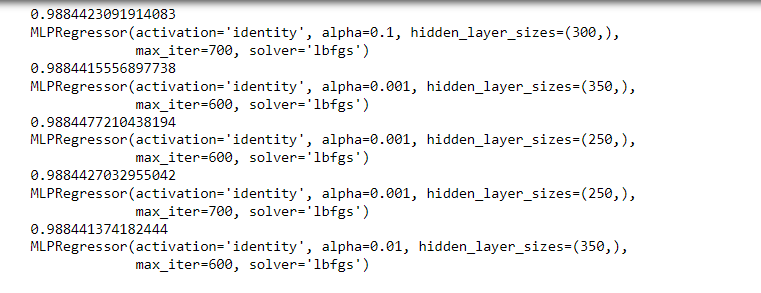

In [57]:
## Set after last cell

best_iter_max = 600
best_layer_size = (350,)
best_activation = 'identity'
best_solver = 'lbfgs'
best_alpha = 0.01

In [58]:
X_train_cv.shape

(1689, 12)

In [59]:
%%time
model_cv = MLPRegressor(hidden_layer_sizes = best_layer_size,
                        max_iter = best_iter_max,
                        activation = best_activation,
                        solver = best_solver,
                        alpha = best_alpha
                        )

model_cv.fit(X_train_cv, y_train_cv)
y_pred_cv = model_cv.predict(X_test_cv)
print(y_pred_cv)
print(y_pred_cv.shape)

[1.6827448  1.68252974 1.76558929 1.82729187 1.89983498 1.90641322
 1.94025898 1.95093584 1.97657064 1.96710312 1.97208957 1.95388976
 1.93682506 1.92224378 1.95414105 1.96373439 1.99294314 2.00201973
 2.02827519 2.05163298 2.03931922 2.01479952 1.99679127 1.93819597
 1.95989619 1.92606126 1.9198391  1.90466014 1.86681968 1.869349
 1.92946469 1.95614276 1.97090369 2.00679342 2.027952   1.96880133
 1.95349838 1.88953956 1.85863286 1.80736666 1.84053894 1.90590706
 1.95280544 2.01740573 2.0541541  2.053389   2.04801661 2.00396198
 1.97269559 1.91633457 1.81128833 1.75219793 1.72227547 1.73739921
 1.74570489 1.77205296 1.70816223 1.71364126 1.6622303  1.65646741
 1.61844963 1.57452765 1.55271476 1.51028855 1.52968866 1.58349902
 1.64545391 1.70315153 1.7108231  1.7355739  1.68068096 1.66087081
 1.62208006 1.61791965 1.66423819 1.64136562 1.5802806  1.55685344
 1.57158594 1.60832511 1.53952708 1.48836326 1.4690886  1.42753493
 1.50262756 1.54388531 1.58362524 1.56931227 1.59898268 1.591416

In [60]:
# Inverse transform the predictions to get them back to the original scale
y_pred = scaler.inverse_transform(y_pred_cv.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test_cv.reshape(-1, 1))

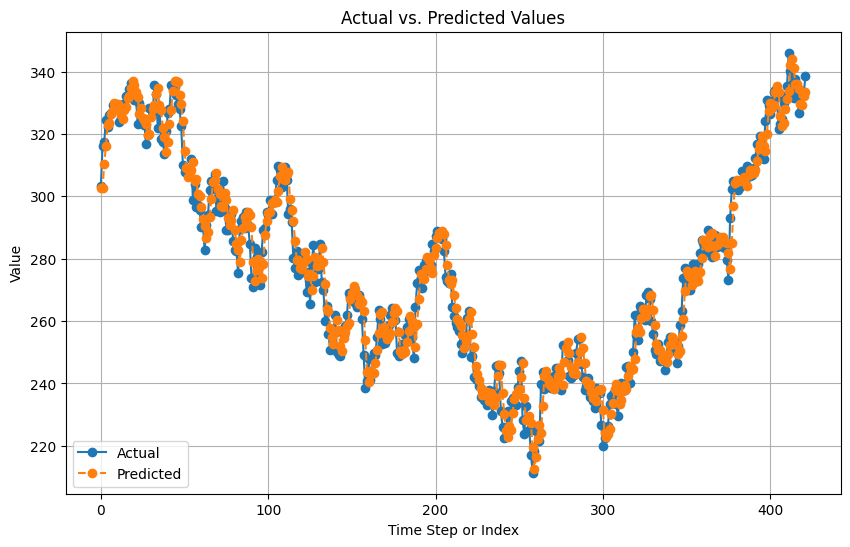

In [61]:
## Evaluate the performance on the Test data
# Create an array for the x-axis (indices or time steps)
x = np.arange(len(y_test))

# Create a line plot for y_pred and y_test
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(x, y_test, label='Actual', marker='o', linestyle='-')
plt.plot(x, y_pred, label='Predicted', marker='o', linestyle='--')

# Add labels and a legend
plt.xlabel('Time Step or Index')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.title('Actual vs. Predicted Values')
plt.grid(True)
plt.show()


In [62]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate R-squared (R2) score
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"RMSE: {rmse}")
print(f"R-squared (R2) Score: {r2}")

Mean Squared Error (MSE): 36.867465730228005
Mean Absolute Error (MAE): 4.863922454141246
RMSE: 6.071858507098795
R-squared (R2) Score: 0.9660252122294083


In [63]:
# trading_dates = msft[end_date:target_date].index.tz_convert(None).normalize()
# trading_dates = trading_dates[1:] # Exclude the 3rd July 2023 because that's part of the Training Data

# # Extend the sequences up to the 10th of July
# extended_input_sequences = input_sequences.copy()  # Make a copy of the input sequences
# extended_output_sequences = output_sequences.copy()  # Make a copy of the output sequences

# for date in trading_dates:
#     # Predict for the next day
#     scaled_predictions = model_cv.predict(extended_input_sequences[-1].reshape(1, -1))  # Predict for the last sequence
#     print('For each date, we can print the `prediction` array ',scaled_predictions, 'and its shape, ', scaled_predictions.shape)
#     # Inverse transform the predictions to get back the original values
#     original_predictions = scaler.inverse_transform(scaled_predictions.reshape(-1, 1))

#     extended_input_sequences = np.vstack((extended_input_sequences, np.append(extended_input_sequences[-1, 1:], scaled_predictions)))
#     extended_output_sequences = np.append(extended_output_sequences, scaled_predictions)

# # Print or use the predictions for July 4th to July 10th
# print("Predictions for July 10th:", extended_output_sequences[-1])

# # Print or use the predictions for July 4th to July 10th
# print("Predictions for July 10th:", extended_output_sequences[-1])